In [100]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

--2023-12-22 03:54:30--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.3’

input.txt.3         100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2023-12-22 03:54:30 (21.3 MB/s) - ‘input.txt.3’ saved [1115394/1115394]



In [101]:
# import the package
import torch
import torch.nn as nn
from torch.nn import functional as F

In [102]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 12000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.2


In [103]:
torch.manual_seed(2001)


# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

### Train with 0 residual connection dropout

In [104]:
torch.manual_seed(2001)

residual_dropout = 0

# cache of train loss and val loss
train_losses_0 = []
val_losses_0 = []

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block with custom residual dropout """

    def __init__(self, n_embd, n_head, residual_dropout=residual_dropout):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.residual_dropout = nn.Dropout(residual_dropout)

    def forward(self, x):
        residual = x
        x = self.sa(self.ln1(x))
        x = residual + self.residual_dropout(x)  # Apply custom dropout to residual connection
        residual = x
        x = self.ffwd(self.ln2(x))
        x = residual + self.residual_dropout(x)  # Apply custom dropout to another residual connection
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx






model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
print('Current residual dropout: ' + str(residual_dropout))



# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses_0.append(losses['train'].item())
        val_losses_0.append(losses['val'].item())
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# # generate from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.209729 M parameters
Current residual dropout: 0
step 0: train loss 4.3456, val loss 4.3521
step 100: train loss 2.6641, val loss 2.6734
step 200: train loss 2.5296, val loss 2.5310
step 300: train loss 2.4541, val loss 2.4533
step 400: train loss 2.3933, val loss 2.4061
step 500: train loss 2.3628, val loss 2.3583
step 600: train loss 2.3032, val loss 2.3169
step 700: train loss 2.2557, val loss 2.2678
step 800: train loss 2.2297, val loss 2.2413
step 900: train loss 2.2028, val loss 2.2133
step 1000: train loss 2.1594, val loss 2.1693
step 1100: train loss 2.1423, val loss 2.1739
step 1200: train loss 2.1197, val loss 2.1535
step 1300: train loss 2.0929, val loss 2.1241
step 1400: train loss 2.0885, val loss 2.1115
step 1500: train loss 2.0648, val loss 2.1070
step 1600: train loss 2.0432, val loss 2.0933
step 1700: train loss 2.0262, val loss 2.0682
step 1800: train loss 2.0207, val loss 2.0636
step 1900: train loss 2.0097, val loss 2.0640
step 2000: train loss 1.9835, val loss 2.0

### Train with 0.01 residual connection dropout

In [105]:
torch.manual_seed(2001)

residual_dropout = 0.01

# cache of train loss and val loss
train_losses_01 = []
val_losses_01= []

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block with custom residual dropout """

    def __init__(self, n_embd, n_head, residual_dropout=residual_dropout):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.residual_dropout = nn.Dropout(residual_dropout)

    def forward(self, x):
        residual = x
        x = self.sa(self.ln1(x))
        x = residual + self.residual_dropout(x)  # Apply custom dropout to residual connection
        residual = x
        x = self.ffwd(self.ln2(x))
        x = residual + self.residual_dropout(x)  # Apply custom dropout to another residual connection
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx






model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
print('Current residual dropout: ' + str(residual_dropout))



# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses_01.append(losses['train'].item())
        val_losses_01.append(losses['val'].item())
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()



# # generate from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.209729 M parameters
Current residual dropout: 0.01
step 0: train loss 4.3456, val loss 4.3521
step 100: train loss 2.6643, val loss 2.6737
step 200: train loss 2.5301, val loss 2.5327
step 300: train loss 2.4503, val loss 2.4497
step 400: train loss 2.3921, val loss 2.4040
step 500: train loss 2.3592, val loss 2.3530
step 600: train loss 2.3013, val loss 2.3156
step 700: train loss 2.2593, val loss 2.2690
step 800: train loss 2.2329, val loss 2.2429
step 900: train loss 2.2040, val loss 2.2159
step 1000: train loss 2.1657, val loss 2.1747
step 1100: train loss 2.1479, val loss 2.1750
step 1200: train loss 2.1242, val loss 2.1559
step 1300: train loss 2.1016, val loss 2.1321
step 1400: train loss 2.0938, val loss 2.1133
step 1500: train loss 2.0638, val loss 2.1021
step 1600: train loss 2.0435, val loss 2.0904
step 1700: train loss 2.0321, val loss 2.0713
step 1800: train loss 2.0281, val loss 2.0662
step 1900: train loss 2.0100, val loss 2.0592
step 2000: train loss 1.9861, val loss 

### Train with 0.025 residual connection dropout

In [106]:
torch.manual_seed(2001)

residual_dropout = 0.025

# cache of train loss and val loss
train_losses_025 = []
val_losses_025 = []

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block with custom residual dropout """

    def __init__(self, n_embd, n_head, residual_dropout=residual_dropout):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.residual_dropout = nn.Dropout(residual_dropout)

    def forward(self, x):
        residual = x
        x = self.sa(self.ln1(x))
        x = residual + self.residual_dropout(x)  # Apply custom dropout to residual connection
        residual = x
        x = self.ffwd(self.ln2(x))
        x = residual + self.residual_dropout(x)  # Apply custom dropout to another residual connection
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx






model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
print('Current residual dropout: ' + str(residual_dropout))



# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses_025.append(losses['train'].item())
        val_losses_025.append(losses['val'].item())
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


# # generate from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.209729 M parameters
Current residual dropout: 0.025
step 0: train loss 4.3456, val loss 4.3521
step 100: train loss 2.6655, val loss 2.6753
step 200: train loss 2.5310, val loss 2.5344
step 300: train loss 2.4521, val loss 2.4513
step 400: train loss 2.3948, val loss 2.4068
step 500: train loss 2.3622, val loss 2.3563
step 600: train loss 2.3040, val loss 2.3185
step 700: train loss 2.2621, val loss 2.2715
step 800: train loss 2.2367, val loss 2.2460
step 900: train loss 2.2068, val loss 2.2185
step 1000: train loss 2.1689, val loss 2.1780
step 1100: train loss 2.1522, val loss 2.1800
step 1200: train loss 2.1285, val loss 2.1604
step 1300: train loss 2.1064, val loss 2.1380
step 1400: train loss 2.0987, val loss 2.1189
step 1500: train loss 2.0682, val loss 2.1060
step 1600: train loss 2.0502, val loss 2.0969
step 1700: train loss 2.0389, val loss 2.0785
step 1800: train loss 2.0314, val loss 2.0699
step 1900: train loss 2.0152, val loss 2.0628
step 2000: train loss 1.9922, val loss

### Train with 0.05 residual connection dropout

In [107]:
torch.manual_seed(2001)

residual_dropout = 0.05

# cache of train loss and val loss
train_losses_05 = []
val_losses_05 = []

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block with custom residual dropout """

    def __init__(self, n_embd, n_head, residual_dropout=residual_dropout):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.residual_dropout = nn.Dropout(residual_dropout)

    def forward(self, x):
        residual = x
        x = self.sa(self.ln1(x))
        x = residual + self.residual_dropout(x)  # Apply custom dropout to residual connection
        residual = x
        x = self.ffwd(self.ln2(x))
        x = residual + self.residual_dropout(x)  # Apply custom dropout to another residual connection
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx






model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
print('Current residual dropout: ' + str(residual_dropout))



# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses_05.append(losses['train'].item())
        val_losses_05.append(losses['val'].item())
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


# # generate from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.209729 M parameters
Current residual dropout: 0.05
step 0: train loss 4.3456, val loss 4.3521
step 100: train loss 2.6673, val loss 2.6774
step 200: train loss 2.5325, val loss 2.5357
step 300: train loss 2.4538, val loss 2.4537
step 400: train loss 2.3970, val loss 2.4093
step 500: train loss 2.3654, val loss 2.3599
step 600: train loss 2.3082, val loss 2.3225
step 700: train loss 2.2676, val loss 2.2759
step 800: train loss 2.2416, val loss 2.2508
step 900: train loss 2.2115, val loss 2.2228
step 1000: train loss 2.1754, val loss 2.1832
step 1100: train loss 2.1587, val loss 2.1860
step 1200: train loss 2.1345, val loss 2.1652
step 1300: train loss 2.1118, val loss 2.1420
step 1400: train loss 2.1047, val loss 2.1232
step 1500: train loss 2.0752, val loss 2.1116
step 1600: train loss 2.0560, val loss 2.1012
step 1700: train loss 2.0453, val loss 2.0829
step 1800: train loss 2.0409, val loss 2.0763
step 1900: train loss 2.0214, val loss 2.0665
step 2000: train loss 2.0017, val loss 

### Train with 0.075 residual connection dropout




In [108]:
torch.manual_seed(2001)

residual_dropout = 0.075

# cache of train loss and val loss
train_losses_075 = []
val_losses_075 = []

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block with custom residual dropout """

    def __init__(self, n_embd, n_head, residual_dropout=residual_dropout):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.residual_dropout = nn.Dropout(residual_dropout)

    def forward(self, x):
        residual = x
        x = self.sa(self.ln1(x))
        x = residual + self.residual_dropout(x)  # Apply custom dropout to residual connection
        residual = x
        x = self.ffwd(self.ln2(x))
        x = residual + self.residual_dropout(x)  # Apply custom dropout to another residual connection
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx






model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
print('Current residual dropout: ' + str(residual_dropout))



# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses_075.append(losses['train'].item())
        val_losses_075.append(losses['val'].item())
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


# # generate from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.209729 M parameters
Current residual dropout: 0.075
step 0: train loss 4.3456, val loss 4.3521
step 100: train loss 2.6690, val loss 2.6792
step 200: train loss 2.5340, val loss 2.5370
step 300: train loss 2.4559, val loss 2.4571
step 400: train loss 2.3990, val loss 2.4110
step 500: train loss 2.3688, val loss 2.3633
step 600: train loss 2.3115, val loss 2.3254
step 700: train loss 2.2710, val loss 2.2789
step 800: train loss 2.2456, val loss 2.2538
step 900: train loss 2.2150, val loss 2.2257
step 1000: train loss 2.1802, val loss 2.1877
step 1100: train loss 2.1628, val loss 2.1892
step 1200: train loss 2.1404, val loss 2.1707
step 1300: train loss 2.1167, val loss 2.1469
step 1400: train loss 2.1115, val loss 2.1272
step 1500: train loss 2.0816, val loss 2.1153
step 1600: train loss 2.0629, val loss 2.1064
step 1700: train loss 2.0524, val loss 2.0876
step 1800: train loss 2.0463, val loss 2.0806
step 1900: train loss 2.0286, val loss 2.0743
step 2000: train loss 2.0080, val loss

### Train with 0.1 residual connection dropout

In [109]:
torch.manual_seed(2001)

residual_dropout = 0.1

# cache of train loss and val loss
train_losses_1 = []
val_losses_1 = []

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block with custom residual dropout """

    def __init__(self, n_embd, n_head, residual_dropout=residual_dropout):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.residual_dropout = nn.Dropout(residual_dropout)

    def forward(self, x):
        residual = x
        x = self.sa(self.ln1(x))
        x = residual + self.residual_dropout(x)  # Apply custom dropout to residual connection
        residual = x
        x = self.ffwd(self.ln2(x))
        x = residual + self.residual_dropout(x)  # Apply custom dropout to another residual connection
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx






model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
print('Current residual dropout: ' + str(residual_dropout))



# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses_1.append(losses['train'].item())
        val_losses_1.append(losses['val'].item())
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


# # generate from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.209729 M parameters
Current residual dropout: 0.1
step 0: train loss 4.3456, val loss 4.3521
step 100: train loss 2.6714, val loss 2.6818
step 200: train loss 2.5357, val loss 2.5387
step 300: train loss 2.4584, val loss 2.4598
step 400: train loss 2.4016, val loss 2.4130
step 500: train loss 2.3716, val loss 2.3652
step 600: train loss 2.3155, val loss 2.3293
step 700: train loss 2.2756, val loss 2.2826
step 800: train loss 2.2515, val loss 2.2586
step 900: train loss 2.2202, val loss 2.2300
step 1000: train loss 2.1860, val loss 2.1922
step 1100: train loss 2.1697, val loss 2.1969
step 1200: train loss 2.1466, val loss 2.1759
step 1300: train loss 2.1227, val loss 2.1516
step 1400: train loss 2.1174, val loss 2.1333
step 1500: train loss 2.0916, val loss 2.1262
step 1600: train loss 2.0701, val loss 2.1129
step 1700: train loss 2.0596, val loss 2.0946
step 1800: train loss 2.0513, val loss 2.0836
step 1900: train loss 2.0367, val loss 2.0797
step 2000: train loss 2.0157, val loss 2

### Train with 0.125 residual connection dropout

In [110]:
torch.manual_seed(2001)

residual_dropout = 0.125

# cache of train loss and val loss
train_losses_125 = []
val_losses_125 = []

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block with custom residual dropout """

    def __init__(self, n_embd, n_head, residual_dropout=residual_dropout):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.residual_dropout = nn.Dropout(residual_dropout)

    def forward(self, x):
        residual = x
        x = self.sa(self.ln1(x))
        x = residual + self.residual_dropout(x)  # Apply custom dropout to residual connection
        residual = x
        x = self.ffwd(self.ln2(x))
        x = residual + self.residual_dropout(x)  # Apply custom dropout to another residual connection
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx






model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
print('Current residual dropout: ' + str(residual_dropout))



# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses_125.append(losses['train'].item())
        val_losses_125.append(losses['val'].item())
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


# # generate from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.209729 M parameters
Current residual dropout: 0.125
step 0: train loss 4.3456, val loss 4.3521
step 100: train loss 2.6726, val loss 2.6832
step 200: train loss 2.5366, val loss 2.5408
step 300: train loss 2.4613, val loss 2.4628
step 400: train loss 2.4051, val loss 2.4164
step 500: train loss 2.3750, val loss 2.3690
step 600: train loss 2.3195, val loss 2.3334
step 700: train loss 2.2809, val loss 2.2881
step 800: train loss 2.2575, val loss 2.2638
step 900: train loss 2.2266, val loss 2.2369
step 1000: train loss 2.1923, val loss 2.1973
step 1100: train loss 2.1759, val loss 2.2022
step 1200: train loss 2.1517, val loss 2.1795
step 1300: train loss 2.1283, val loss 2.1559
step 1400: train loss 2.1249, val loss 2.1394
step 1500: train loss 2.0986, val loss 2.1306
step 1600: train loss 2.0780, val loss 2.1194
step 1700: train loss 2.0658, val loss 2.0975
step 1800: train loss 2.0586, val loss 2.0893
step 1900: train loss 2.0432, val loss 2.0836
step 2000: train loss 2.0219, val loss

### Train with 0.15 residual connection dropout

In [111]:
torch.manual_seed(2001)

residual_dropout = 0.15

# cache of train loss and val loss
train_losses_15 = []
val_losses_15 = []

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block with custom residual dropout """

    def __init__(self, n_embd, n_head, residual_dropout=residual_dropout):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.residual_dropout = nn.Dropout(residual_dropout)

    def forward(self, x):
        residual = x
        x = self.sa(self.ln1(x))
        x = residual + self.residual_dropout(x)  # Apply custom dropout to residual connection
        residual = x
        x = self.ffwd(self.ln2(x))
        x = residual + self.residual_dropout(x)  # Apply custom dropout to another residual connection
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx






model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
print('Current residual dropout: ' + str(residual_dropout))



# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses_15.append(losses['train'].item())
        val_losses_15.append(losses['val'].item())
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


# # generate from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.209729 M parameters
Current residual dropout: 0.15
step 0: train loss 4.3456, val loss 4.3521
step 100: train loss 2.6750, val loss 2.6861
step 200: train loss 2.5388, val loss 2.5431
step 300: train loss 2.4649, val loss 2.4663
step 400: train loss 2.4074, val loss 2.4188
step 500: train loss 2.3792, val loss 2.3734
step 600: train loss 2.3241, val loss 2.3381
step 700: train loss 2.2855, val loss 2.2932
step 800: train loss 2.2643, val loss 2.2698
step 900: train loss 2.2326, val loss 2.2425
step 1000: train loss 2.1976, val loss 2.2020
step 1100: train loss 2.1811, val loss 2.2067
step 1200: train loss 2.1578, val loss 2.1839
step 1300: train loss 2.1364, val loss 2.1633
step 1400: train loss 2.1306, val loss 2.1454
step 1500: train loss 2.1066, val loss 2.1377
step 1600: train loss 2.0839, val loss 2.1248
step 1700: train loss 2.0715, val loss 2.1025
step 1800: train loss 2.0652, val loss 2.0954
step 1900: train loss 2.0518, val loss 2.0913
step 2000: train loss 2.0276, val loss 

### Train with 0.175 residual connection dropout

In [112]:
torch.manual_seed(2001)

residual_dropout = 0.175

# cache of train loss and val loss
train_losses_175 = []
val_losses_175 = []

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block with custom residual dropout """

    def __init__(self, n_embd, n_head, residual_dropout=residual_dropout):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.residual_dropout = nn.Dropout(residual_dropout)

    def forward(self, x):
        residual = x
        x = self.sa(self.ln1(x))
        x = residual + self.residual_dropout(x)  # Apply custom dropout to residual connection
        residual = x
        x = self.ffwd(self.ln2(x))
        x = residual + self.residual_dropout(x)  # Apply custom dropout to another residual connection
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx






model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
print('Current residual dropout: ' + str(residual_dropout))



# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses_175.append(losses['train'].item())
        val_losses_175.append(losses['val'].item())
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


# # generate from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.209729 M parameters
Current residual dropout: 0.175
step 0: train loss 4.3456, val loss 4.3521
step 100: train loss 2.6774, val loss 2.6887
step 200: train loss 2.5404, val loss 2.5454
step 300: train loss 2.4680, val loss 2.4700
step 400: train loss 2.4101, val loss 2.4211
step 500: train loss 2.3832, val loss 2.3775
step 600: train loss 2.3270, val loss 2.3412
step 700: train loss 2.2900, val loss 2.2968
step 800: train loss 2.2686, val loss 2.2734
step 900: train loss 2.2388, val loss 2.2473
step 1000: train loss 2.2023, val loss 2.2063
step 1100: train loss 2.1862, val loss 2.2109
step 1200: train loss 2.1638, val loss 2.1885
step 1300: train loss 2.1414, val loss 2.1669
step 1400: train loss 2.1382, val loss 2.1520
step 1500: train loss 2.1156, val loss 2.1471
step 1600: train loss 2.0923, val loss 2.1325
step 1700: train loss 2.0794, val loss 2.1079
step 1800: train loss 2.0708, val loss 2.1003
step 1900: train loss 2.0570, val loss 2.0954
step 2000: train loss 2.0326, val loss

### Train with 0.2 residual connection dropout rate

In [113]:
torch.manual_seed(2001)

residual_dropout = 0.2

# cache of train loss and val loss
train_losses_2 = []
val_losses_2 = []

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block with custom residual dropout """

    def __init__(self, n_embd, n_head, residual_dropout=residual_dropout):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.residual_dropout = nn.Dropout(residual_dropout)

    def forward(self, x):
        residual = x
        x = self.sa(self.ln1(x))
        x = residual + self.residual_dropout(x)  # Apply custom dropout to residual connection
        residual = x
        x = self.ffwd(self.ln2(x))
        x = residual + self.residual_dropout(x)  # Apply custom dropout to another residual connection
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx






model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
print('Current residual dropout: ' + str(residual_dropout))



# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses_2.append(losses['train'].item())
        val_losses_2.append(losses['val'].item())
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


# # generate from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.209729 M parameters
Current residual dropout: 0.2
step 0: train loss 4.3456, val loss 4.3521
step 100: train loss 2.6808, val loss 2.6921
step 200: train loss 2.5422, val loss 2.5473
step 300: train loss 2.4701, val loss 2.4724
step 400: train loss 2.4139, val loss 2.4242
step 500: train loss 2.3885, val loss 2.3826
step 600: train loss 2.3313, val loss 2.3448
step 700: train loss 2.2949, val loss 2.3016
step 800: train loss 2.2734, val loss 2.2782
step 900: train loss 2.2449, val loss 2.2526
step 1000: train loss 2.2072, val loss 2.2106
step 1100: train loss 2.1922, val loss 2.2166
step 1200: train loss 2.1680, val loss 2.1916
step 1300: train loss 2.1472, val loss 2.1716
step 1400: train loss 2.1443, val loss 2.1574
step 1500: train loss 2.1220, val loss 2.1498
step 1600: train loss 2.1010, val loss 2.1400
step 1700: train loss 2.0862, val loss 2.1134
step 1800: train loss 2.0787, val loss 2.1047
step 1900: train loss 2.0645, val loss 2.1002
step 2000: train loss 2.0418, val loss 2

In [114]:
import matplotlib.pyplot as plt

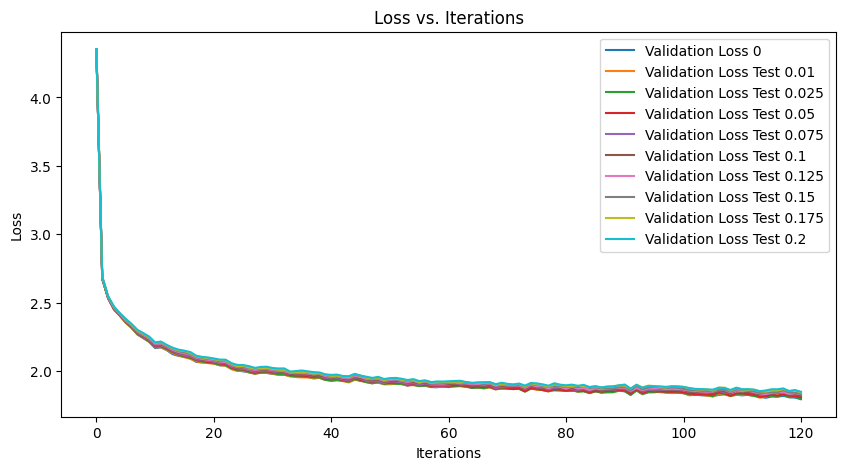

In [115]:
plt.figure(figsize=(10, 5))
# plt.plot(train_losses_0, label='Train Loss 0')
plt.plot(val_losses_0, label='Validation Loss 0')

# plt.plot(train_losses_01, label='Train Loss Test 0.01')
plt.plot(val_losses_01, label='Validation Loss Test 0.01')

# plt.plot(train_losses_025, label='Train Loss Test 0.025')
plt.plot(val_losses_025, label='Validation Loss Test 0.025')

# plt.plot(train_losses_05, label='Train Loss Test 0.05')
plt.plot(val_losses_05, label='Validation Loss Test 0.05')

# plt.plot(train_losses_075, label='Train Loss Test 0.075')
plt.plot(val_losses_075, label='Validation Loss Test 0.075')

# plt.plot(train_losses_1, label='Train Loss Test 0.1')
plt.plot(val_losses_1, label='Validation Loss Test 0.1')

# plt.plot(train_losses_125, label='Train Loss Test 0.125')
plt.plot(val_losses_125, label='Validation Loss Test 0.125')

# plt.plot(train_losses_15, label='Train Loss Test 0.15')
plt.plot(val_losses_15, label='Validation Loss Test 0.15')

# plt.plot(train_losses_175, label='Train Loss Test 0.175')
plt.plot(val_losses_175, label='Validation Loss Test 0.175')

# plt.plot(train_losses_2, label='Train Loss Test 0.2')
plt.plot(val_losses_2, label='Validation Loss Test 0.2')


plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.legend()
# plt.show()

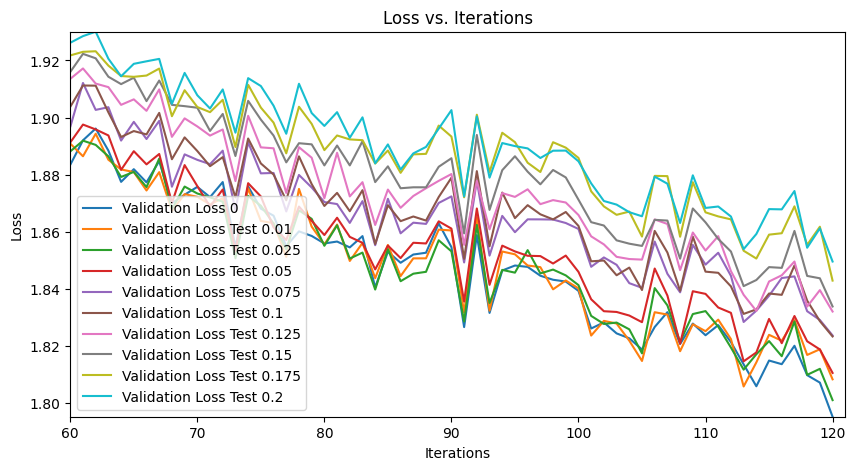

In [116]:
plt.figure(figsize=(10, 5))
# plt.plot(train_losses_0, label='Train Loss 0')
plt.plot(val_losses_0, label='Validation Loss 0')

# plt.plot(train_losses_01, label='Train Loss Test 0.01')
plt.plot(val_losses_01, label='Validation Loss Test 0.01')

# plt.plot(train_losses_025, label='Train Loss Test 0.025')
plt.plot(val_losses_025, label='Validation Loss Test 0.025')

# plt.plot(train_losses_05, label='Train Loss Test 0.05')
plt.plot(val_losses_05, label='Validation Loss Test 0.05')

# plt.plot(train_losses_075, label='Train Loss Test 0.075')
plt.plot(val_losses_075, label='Validation Loss Test 0.075')

# plt.plot(train_losses_1, label='Train Loss Test 0.1')
plt.plot(val_losses_1, label='Validation Loss Test 0.1')

# plt.plot(train_losses_125, label='Train Loss Test 0.125')
plt.plot(val_losses_125, label='Validation Loss Test 0.125')

# plt.plot(train_losses_15, label='Train Loss Test 0.15')
plt.plot(val_losses_15, label='Validation Loss Test 0.15')

# plt.plot(train_losses_175, label='Train Loss Test 0.175')
plt.plot(val_losses_175, label='Validation Loss Test 0.175')

# plt.plot(train_losses_2, label='Train Loss Test 0.2')
plt.plot(val_losses_2, label='Validation Loss Test 0.2')


plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.legend()
# plt.show()

# Focus on the latter half of the iterations
num_iterations = len(val_losses_0)  # Use the actual number of iterations
start_point = num_iterations // 2  # Starting from the halfway point

plt.xlim(start_point, num_iterations)  # Set x-axis limits to focus on the latter half

# Adjusting the y-axis range
# Calculate the maximum and minimum loss values in the focused range
max_loss = max(max(val_losses_0[start_point:]),
               max(val_losses_01[start_point:]),
               max(val_losses_025[start_point:]),
               max(val_losses_05[start_point:]),
               max(val_losses_075[start_point:]),
               max(val_losses_1[start_point:]),
               max(val_losses_125[start_point:]),
               max(val_losses_15[start_point:]),
               max(val_losses_175[start_point:]),
               max(val_losses_2[start_point:]))


min_loss = min(min(val_losses_0[start_point:]),
               min(val_losses_01[start_point:]),
               min(val_losses_025[start_point:]),
               min(val_losses_05[start_point:]),
               min(val_losses_075[start_point:]),
               min(val_losses_1[start_point:]),
               min(val_losses_125[start_point:]),
               min(val_losses_15[start_point:]),
               min(val_losses_175[start_point:]),
               min(val_losses_2[start_point:]))

plt.ylim(min_loss, max_loss)  # Set y-axis limits to enhance the loss variation

# Display the plot
plt.show()

In [117]:
# Define moving average function
def moving_average(data, window_size):
    """Calculate the moving average of a list of numbers."""
    if not data or len(data) < window_size:
        return []
    return [sum(data[i:i+window_size]) / window_size for i in range(len(data) - window_size + 1)]

In [118]:
# Set window size to 3
window_size = 5

In [119]:
train_losses_0_mal = moving_average(train_losses_0, window_size)
val_losses_0_mal = moving_average(val_losses_0, window_size)

train_losses_01_mal = moving_average(train_losses_01, window_size)
val_losses_01_mal = moving_average(val_losses_01, window_size)

train_losses_025_mal = moving_average(train_losses_025, window_size)
val_losses_025_mal = moving_average(val_losses_025, window_size)

train_losses_05_mal = moving_average(train_losses_05, window_size)
val_losses_05_mal = moving_average(val_losses_05, window_size)

train_losses_075_mal = moving_average(train_losses_075, window_size)
val_losses_075_mal = moving_average(val_losses_075, window_size)

train_losses_1_mal = moving_average(train_losses_1, window_size)
val_losses_1_mal = moving_average(val_losses_1, window_size)

train_losses_125_mal = moving_average(train_losses_125, window_size)
val_losses_125_mal = moving_average(val_losses_125, window_size)

train_losses_15_mal = moving_average(train_losses_15, window_size)
val_losses_15_mal = moving_average(val_losses_15, window_size)

train_losses_175_mal = moving_average(train_losses_175, window_size)
val_losses_175_mal = moving_average(val_losses_175, window_size)

train_losses_2_mal = moving_average(train_losses_2, window_size)
val_losses_2_mal = moving_average(val_losses_2, window_size)




In [120]:
from tabulate import tabulate


# Headers for each column (iterations)
headers = ['Iteration ' + str(i+1) for i in range(len(train_losses_0))]

# Arrange the data with train losses and validation losses in separate rows
data = [
    val_losses_0,
    val_losses_01,
    val_losses_025,
    val_losses_05,
    val_losses_075,
    val_losses_1,
    val_losses_125,
    val_losses_15,
    val_losses_175,
    val_losses_2
]

# Create table and print
print(tabulate(data,
               headers=headers,
               tablefmt="grid",
               showindex=["Val Losses 0",
                          "Val Losses 0.1",
                          "Val Losses 0.25",
                          "Val Losses 0.5",
                          "Val Losses 0.75",
                          "Val Losses 1",
                          "Val Losses 1.25",
                          "Val Losses 1.5",
                          "Val Losses 1.75",
                          "Val Losses 2"]))


+-----------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----

In [121]:
# Headers for each column (iterations)
headers_mal = ['Iteration ' + str(i+1) for i in range(len(train_losses_0_mal))]

# Arrange the data with train losses and validation losses in separate rows
data_mal = [
    val_losses_0_mal,
    val_losses_01_mal,
    val_losses_025_mal,
    val_losses_05_mal,
    val_losses_075_mal,
    val_losses_1_mal,
    val_losses_125_mal,
    val_losses_15_mal,
    val_losses_175_mal,
    val_losses_2_mal
]

# Create table and print
print(tabulate(data_mal,
               headers=headers_mal,
               tablefmt="grid",
               showindex=["Val Losses 0",
                          "Val Losses 0.1",
                          "Val Losses 0.25",
                          "Val Losses 0.5",
                          "Val Losses 0.75",
                          "Val Losses 1",
                          "Val Losses 1.25",
                          "Val Losses 1.5",
                          "Val Losses 1.75",
                          "Val Losses 2"]))


+-----------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----